In [4]:
import gymnasium as gym

from IPython.display import clear_output
from IPython.utils import io
import matplotlib.pyplot as plt
 
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras

### Creating environment 

In [5]:
env = gym.make('CartPole-v1')

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.n

In [6]:
# Hyperparameters:
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.015
epsilon_decay = 0.99
learning_rate = 0.01
max_steps = 500
batch_size = 32
max_episodes = 500
buffer_size = 1000
q_network_train_step_interval = 4
target_step_update_interval = 128

In [ ]:
# Creating the replay buffer class to store the experiences of the agent
class ReplayBuffer:
     # I need to store the experiences in the buffer 
    def __init__ (self, capacity): 
       # I am going to define attributes for my class
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        
    # Function to store the experiences in the buffer
    def store(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
            
        self.buffer[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        
   # For better training, I need to sample the experiences from the buffer     
   # Sample function makes experiences randomly from the buffer
    def sample(self, batch_size):
       
        indicate = np.random.choice(len(self.buffer), batch_size, replace=False) 
        batch = [self.buffer[i] for i in indicate]  
        state, action, reward, next_state, done = map(np.array, zip(*batch)) 
        return state, action, reward, next_state, done
    
    def size(self):
     return len(self.buffer)                              

###  Build the neural networks (Q-network + target network)

In [8]:
def create_q_network(): 
    
    model = keras.models.Sequential([
        keras.layers.Dense(128, input_shape=(state_dim,), activation='relu'),
        keras.layers.Dense(action_dim, activation='linear')
    ])   
    
    # compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="mse")
    return model

q_network = create_q_network()
target_network = create_q_network()

target_network.set_weights(q_network.get_weights())
replay_buffer = ReplayBuffer(buffer_size)               

c:\Users\murta\Desktop\ML&DE\Fourth_Semester\Reinforcement_learning\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Creating the select action function for balancing exploration and exploitation
def select_action (state, epsilon):
    
    if np.random.rand() < epsilon:
         # Taking random action
        return np.random.choice(action_dim)
    # I am gonna use np.expand_dims to add a new axis to the state
    state = np.expand_dims(state, axis=0)
    with io.capture_output() as captured:
        q_values = q_network.predict(state)
    return np.argmax(q_values)



def train_step():
    # I am gonna to check if the replay buffer has enough experiences to sample
    if replay_buffer.size() < batch_size:
      return
 # I am gonna to sample a batch of experiences from the replay buffer
    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, done = batch
    
    # I am gonna to calculate the targets for the q-network
    state_q_values = q_network.predict(states, verbose=0)
    # By using the target network, I am gonna to calculate the next state q-values
    next_state_q_values = target_network.predict(next_states, verbose=0)
    targets = state_q_values.copy()
    
    
    # I am gonna use for loop to calculate the targets for each experience in the batch
    for i in range(batch_size):
        if done [i]:
        # if the episode is done, so there is no future rewards
           targets[i, actions[i]] = rewards[i]      
        else:
        # if the episode is not done, so I am gonna to calculate the future rewards by using the Bellman equation
           targets[i, actions[i]] = rewards[i] + gamma * np.max(next_state_q_values[i])
           
               
    with io.capture_output() as captured:
        loss = q_network.train_on_batch(states, targets)
    return loss

### Training Loop

In [10]:
losses = []
rewards = []
variances = []


total_steps = 0 

for episode in range(max_episodes):
    state, info = env.reset()
    total_reward = 0
    
    
    for step in range(max_steps):
         
       action = select_action(state, epsilon)
       next_state, reward, done, truncated, info = env.step(action)
       replay_buffer.store((state, action, reward, next_state, done))
        # update the state for future
       state = next_state
       total_reward += reward
       total_steps += 1
       
       # Q-network training step
       if total_steps % q_network_train_step_interval == 0:
            loss = train_step()
            losses.append(loss)
            
       if total_steps % target_step_update_interval == 0:
            # Updating the target network
            target_network.set_weights(q_network.get_weights())
            
            
       if done:
          break
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    
     # show progress while training
    print(f"Total steps: {total_steps}")
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")
    
    
    if total_reward >= (max_steps - 5) and epsilon == epsilon_min:
        print(f"Solved Cart Pole in {episode + 1} episodes!")
        break
    # log the results for metrics
    rewards.append(total_reward)
    variances.append(np.var(rewards))

Total steps: 61
Episode 1: Total Reward = 61.00, Epsilon = 0.990
Total steps: 75
Episode 2: Total Reward = 14.00, Epsilon = 0.980
Total steps: 89
Episode 3: Total Reward = 14.00, Epsilon = 0.970
Total steps: 119
Episode 4: Total Reward = 30.00, Epsilon = 0.961
Total steps: 129
Episode 5: Total Reward = 10.00, Epsilon = 0.951
Total steps: 157
Episode 6: Total Reward = 28.00, Epsilon = 0.941
Total steps: 179
Episode 7: Total Reward = 22.00, Epsilon = 0.932
Total steps: 188
Episode 8: Total Reward = 9.00, Epsilon = 0.923
Total steps: 227
Episode 9: Total Reward = 39.00, Epsilon = 0.914
Total steps: 249
Episode 10: Total Reward = 22.00, Epsilon = 0.904
Total steps: 266
Episode 11: Total Reward = 17.00, Epsilon = 0.895
Total steps: 280
Episode 12: Total Reward = 14.00, Epsilon = 0.886
Total steps: 317
Episode 13: Total Reward = 37.00, Epsilon = 0.878
Total steps: 337
Episode 14: Total Reward = 20.00, Epsilon = 0.869
Total steps: 352
Episode 15: Total Reward = 15.00, Epsilon = 0.860
Total st

Variance over time


Text(0.5, 0, 'Rewards')

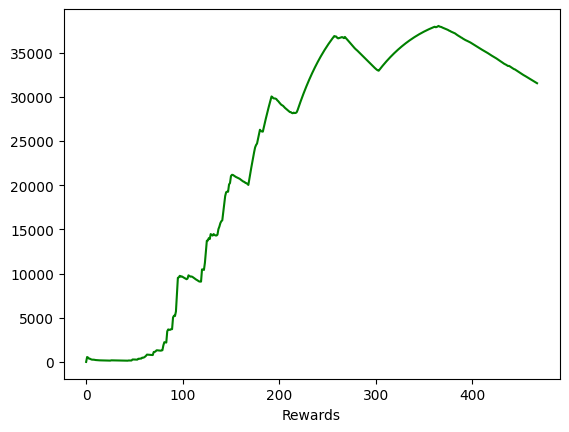

In [11]:
# visualize variance over time
print("Variance over time")
plt.plot(variances, color="green")
plt.xlabel("Rewards")   

Neural network losses over time


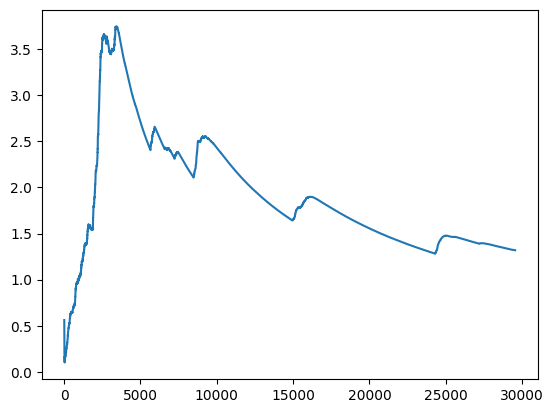

In [12]:
print("Neural network losses over time")
plt.plot(losses)

Rewards by episode


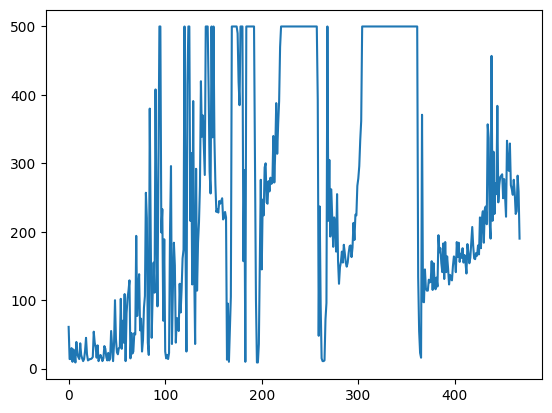

In [13]:
# let's see the rewards progression
print("Rewards by episode")
plt.plot(rewards)
plt.show()

Rewards w/ running mean:


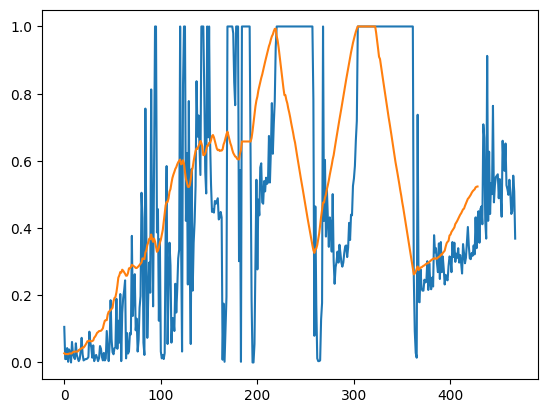

In [14]:
# convert the rewards -list into NumPy -array format
rewards_arr = np.array(rewards)
window_size = 40

# normalize the rewards (manual MinMax -normalization)
normalized_rewards = (rewards_arr - min(rewards_arr)) / (max(rewards_arr) - min(rewards_arr))

# calculate the running mean
running_mean = np.convolve(normalized_rewards, np.ones(window_size) / window_size, mode="valid")

print("Rewards w/ running mean:")
# visualize rewards + RUNNING MEAN
plt.plot(normalized_rewards)
plt.plot(running_mean)
plt.show()

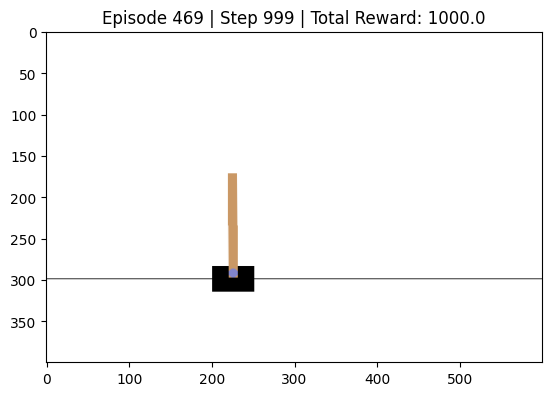

In [15]:
# make a new environment for the test
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()
total_reward = 0

# play the environment
for step in range(1000):
    action = select_action(state, epsilon)
    state, reward, done, truncated, info = env.step(action)
    total_reward += reward

    # visualize frame
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.title(f'Episode {episode+1} | Step {step} | Total Reward: {total_reward}')
    plt.pause(0.01) 

    if done:
        break

# close the environment
env.close()
plt.close()